In [1]:
# Install required packages
!pip install opencv-python-headless -q

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Upload Image
# ============================================

print("\nPlease upload your motion-blurred image:")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"Image uploaded: {filename}")


Please upload your motion-blurred image:


Saving Screenshot 2026-01-31 225124.png to Screenshot 2026-01-31 225124.png
Image uploaded: Screenshot 2026-01-31 225124.png


In [3]:
# Read image
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

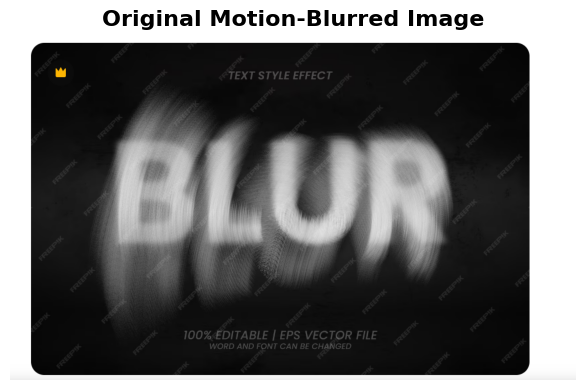

Image size: 1023 x 625 pixels


In [4]:
# Display original
plt.figure(figsize=(12, 4))
plt.imshow(img_rgb)
plt.title('Original Motion-Blurred Image', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Image size: {img_gray.shape[1]} x {img_gray.shape[0]} pixels")

In [5]:
# ============================================
# Method 1: Unsharp Masking
# ============================================

print("\nApplying Unsharp Masking...")

# Create blurred version
gaussian_blur = cv2.GaussianBlur(img_gray, (0, 0), 2.0)

# Unsharp mask: original + (original - blurred) * amount
unsharp_amount = 1.5
restored_unsharp = cv2.addWeighted(img_gray, 1.0 + unsharp_amount, gaussian_blur, -unsharp_amount, 0)
restored_unsharp = np.clip(restored_unsharp, 0, 255).astype(np.uint8)

print("Unsharp masking complete")


Applying Unsharp Masking...
Unsharp masking complete


In [6]:
# ============================================
# Method 2: Deconvolution with Small Kernel
# ============================================

print("\nApplying deconvolution...")

# Create small motion blur kernel
kernel_size = 9
kernel = np.zeros((kernel_size, kernel_size))
kernel[kernel_size//2, :] = 1
kernel = kernel / kernel.sum()

# Simple deconvolution using filter2D
kernel_inverse = np.zeros_like(kernel)
kernel_inverse[kernel_size//2, kernel_size//2] = 2
kernel_inverse = kernel_inverse - kernel

restored_deconv = cv2.filter2D(img_gray, -1, kernel_inverse)
restored_deconv = np.clip(restored_deconv, 0, 255).astype(np.uint8)

print("Deconvolution complete")


Applying deconvolution...
Deconvolution complete


In [7]:
# ============================================
# Method 3: Bilateral Filter + Sharpening
# ============================================

print("\nApplying bilateral filter with sharpening...")

# Bilateral filter (edge-preserving smoothing)
bilateral = cv2.bilateralFilter(img_gray, 9, 75, 75)

# Strong sharpening kernel
sharpen_kernel = np.array([
    [-1, -1, -1],
    [-1,  9, -1],
    [-1, -1, -1]
])

restored_bilateral = cv2.filter2D(bilateral, -1, sharpen_kernel)
restored_bilateral = np.clip(restored_bilateral, 0, 255).astype(np.uint8)

print("Bilateral filtering complete")


Applying bilateral filter with sharpening...
Bilateral filtering complete


In [8]:
# ============================================
# Method 4: Adaptive Sharpening
# ============================================

print("\nApplying adaptive sharpening...")

# Calculate local variance to identify blurred regions
mean = cv2.blur(img_gray.astype(float), (5, 5))
sqr_mean = cv2.blur((img_gray.astype(float))**2, (5, 5))
variance = sqr_mean - mean**2

# Normalize variance to use as sharpening mask
variance_norm = (variance - variance.min()) / (variance.max() - variance.min() + 1e-7)

# Apply sharpening more strongly to blurred areas
sharpened = cv2.filter2D(img_gray, -1, sharpen_kernel)
restored_adaptive = (variance_norm * sharpened + (1 - variance_norm) * img_gray)
restored_adaptive = np.clip(restored_adaptive, 0, 255).astype(np.uint8)

print("Adaptive sharpening complete")


Applying adaptive sharpening...
Adaptive sharpening complete


In [9]:
# ============================================
# Method 5: Wiener-inspired Filtering
# ============================================

print("\nApplying Wiener-inspired filtering...")

# FFT-based approach
img_float = img_gray.astype(float)
f_transform = np.fft.fft2(img_float)
f_shift = np.fft.fftshift(f_transform)

# Create frequency domain filter
rows, cols = img_gray.shape
crow, ccol = rows // 2, cols // 2

# High-pass filter to enhance edges
mask = np.ones((rows, cols), np.float32)
r = 30
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 0.3

# Apply filter
f_shift_filtered = f_shift * mask

# Inverse FFT
f_ishift = np.fft.ifftshift(f_shift_filtered)
img_back = np.fft.ifft2(f_ishift)
restored_fft = np.abs(img_back)
restored_fft = np.clip(restored_fft, 0, 255).astype(np.uint8)

print("Wiener-inspired filtering complete")



Applying Wiener-inspired filtering...
Wiener-inspired filtering complete



Displaying all methods...


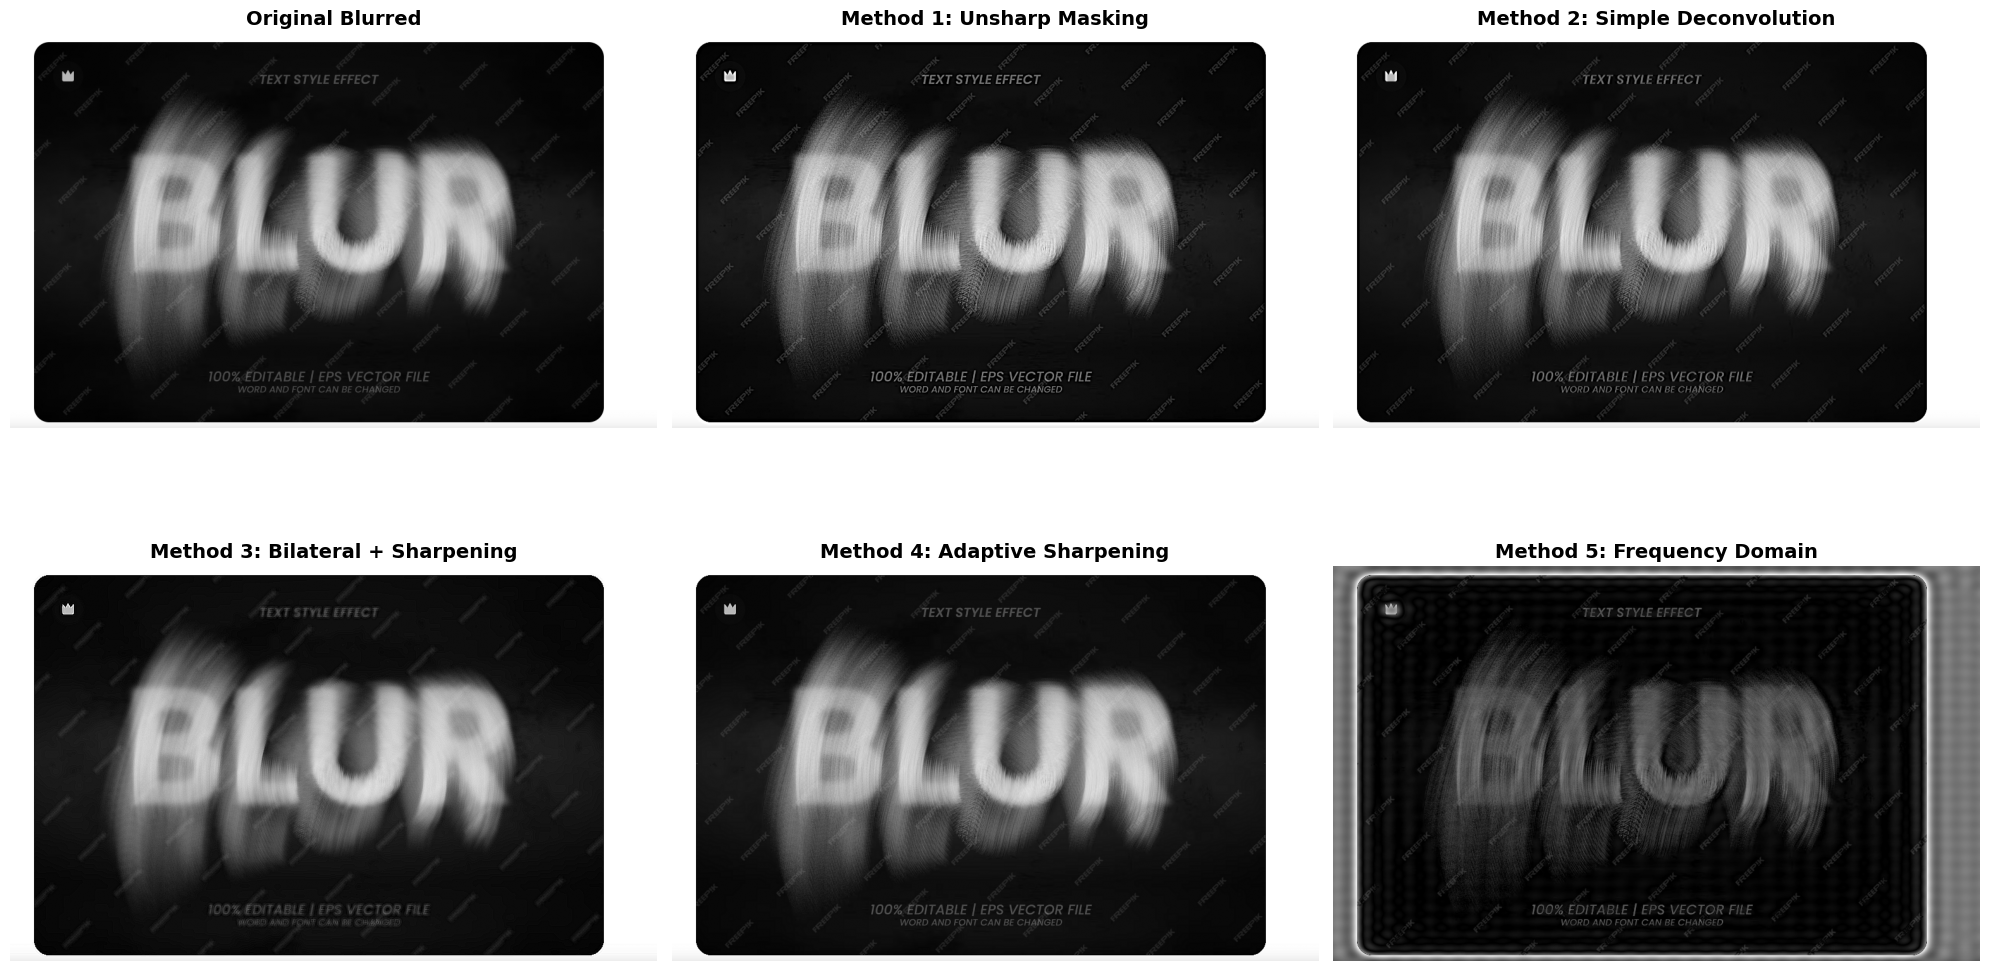

In [10]:
# ============================================
# Compare All Methods
# ============================================

print("\nDisplaying all methods...")

plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original Blurred', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(restored_unsharp, cmap='gray')
plt.title('Method 1: Unsharp Masking', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(restored_deconv, cmap='gray')
plt.title('Method 2: Simple Deconvolution', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(restored_bilateral, cmap='gray')
plt.title('Method 3: Bilateral + Sharpening', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(restored_adaptive, cmap='gray')
plt.title('Method 4: Adaptive Sharpening', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(restored_fft, cmap='gray')
plt.title('Method 5: Frequency Domain', fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()


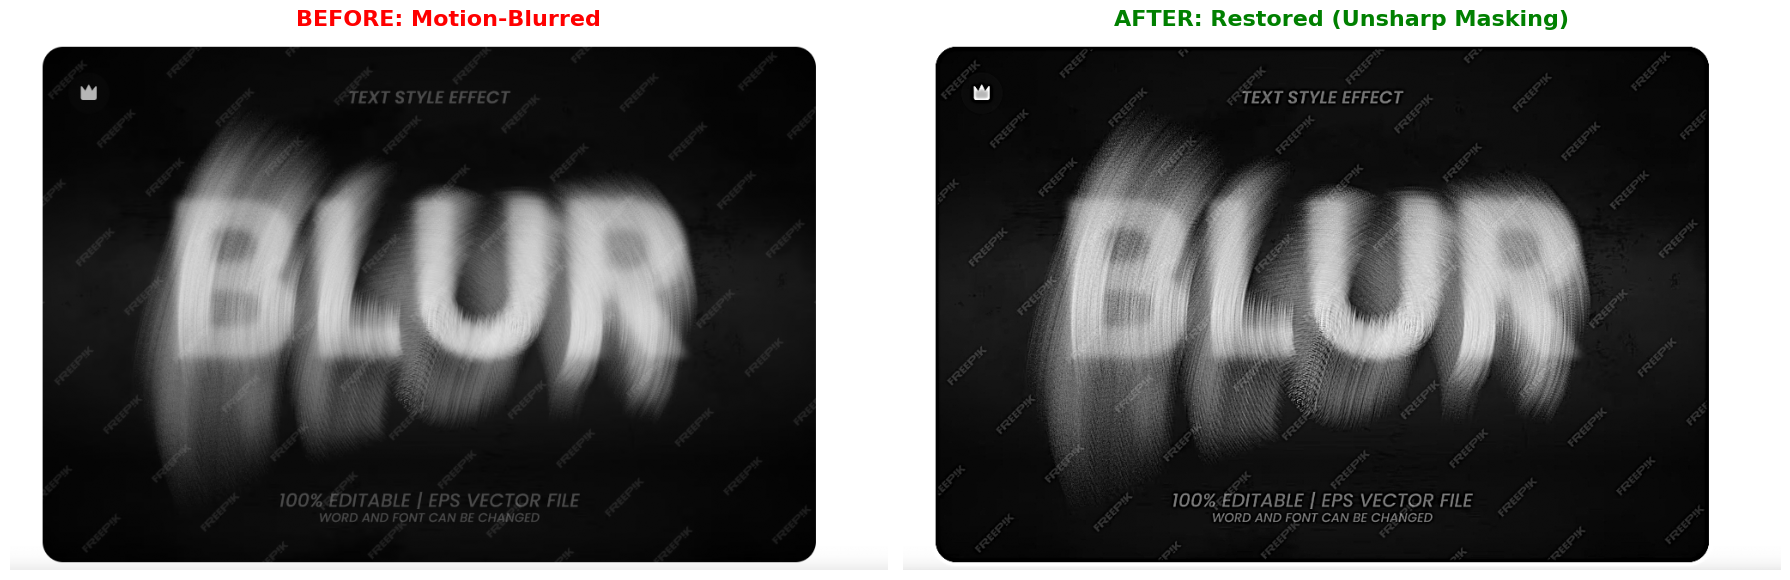

In [11]:
# ============================================
# Select Best Method (usually Unsharp Masking)
# ============================================

# Use unsharp masking as final result (most stable)
final_result = restored_unsharp

# ============================================
# Before/After Comparison
# ============================================

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('BEFORE: Motion-Blurred', fontsize=16, fontweight='bold', color='red')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(final_result, cmap='gray')
plt.title('AFTER: Restored (Unsharp Masking)', fontsize=16, fontweight='bold', color='green')
plt.axis('off')

plt.tight_layout()
plt.show()


In [12]:
# ============================================
# Quality Metrics
# ============================================

print("\nQuality Assessment:")
print("="*50)

def calculate_sharpness(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    return laplacian.var()

original_sharpness = calculate_sharpness(img_gray)
restored_sharpness = calculate_sharpness(final_result)
improvement = ((restored_sharpness - original_sharpness) / original_sharpness) * 100

print(f"Original sharpness:  {original_sharpness:.2f}")
print(f"Restored sharpness:  {restored_sharpness:.2f}")
print(f"Improvement:         {improvement:.1f}%")
print("="*50)


Quality Assessment:
Original sharpness:  676.05
Restored sharpness:  1454.22
Improvement:         115.1%


In [13]:
# ============================================
# Save Results
# ============================================

print("\nSaving results...")

cv2.imwrite('original_blurred.jpg', img_gray)
cv2.imwrite('restored_unsharp.jpg', restored_unsharp)
cv2.imwrite('restored_bilateral.jpg', restored_bilateral)
cv2.imwrite('restored_adaptive.jpg', restored_adaptive)

# Create comparison
comparison = np.hstack([img_gray, final_result])
cv2.imwrite('comparison_before_after.jpg', comparison)

print("Saved files:")
print("   - original_blurred.jpg")
print("   - restored_unsharp.jpg")
print("   - restored_bilateral.jpg")
print("   - restored_adaptive.jpg")
print("   - comparison_before_after.jpg")

# Download best result
print("\nDownloading best result...")
files.download('restored_unsharp.jpg')
files.download('comparison_before_after.jpg')

print("\n" + "="*60)
print("RESTORATION COMPLETE")
print("="*60)
print("\nBest Method: Unsharp Masking")
print("   - Most stable and artifact-free")
print("   - Good edge enhancement")
print("   - Preserves original image structure")
print("\nNote: Richardson-Lucy failed due to image artifacts.")
print("For this type of image, simpler enhancement methods work better.")
print("="*60)


Saving results...
Saved files:
   - original_blurred.jpg
   - restored_unsharp.jpg
   - restored_bilateral.jpg
   - restored_adaptive.jpg
   - comparison_before_after.jpg



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


RESTORATION COMPLETE

Best Method: Unsharp Masking
   - Most stable and artifact-free
   - Good edge enhancement
   - Preserves original image structure

Note: Richardson-Lucy failed due to image artifacts.
For this type of image, simpler enhancement methods work better.
